In [1]:
import os
import json
import math
import string

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

In [2]:
# Путь к папке с JSON файлами
json_folder_path = '/kaggle/input/hkr-dataset/20200923_Dataset_Words_Public/ann'

# Создаем пустые списки для данных
names = []
descriptions = []

# Проходим по всем файлам в указанной папке
for filename in os.listdir(json_folder_path):
    if filename.endswith('.json'):  # Проверяем, что это JSON файл
        file_path = os.path.join(json_folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            # Добавляем значения в списки
            names.append(data.get('name'))
            descriptions.append(data.get('description'))

# Создаем DataFrame
gt = pd.DataFrame({
    'fn': names,
    'value': descriptions
})

gt.head(10)

,fn,value
0,10_21_55,Россия
1,1_50_108,джигиту
2,10_35_348,Северно-Казахстанская
3,9_13_568,"Стог высится,"
4,12_12_114,Зыряновск
5,6_25_778,Своей рукой убрал
6,10_10_426,Караганда
7,10_14_357,Петропавловск
8,2_31_178,"не всегда,"
9,2_45_673,святых видений


In [9]:
widths = []
heights = []

# Проходим по всем файлам в указанной папке
for filename in os.listdir(json_folder_path):
    if filename.endswith('.json'):  # Проверяем, что это JSON файл
        file_path = os.path.join(json_folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            size = data.get('size', {})
            # Извлекаем значения ширины и высоты и добавляем в списки
            widths.append(size.get('width'))
            heights.append(size.get('height'))

# Создаем DataFrame
df = pd.DataFrame({
    'width': widths,
    'height': heights
})

df.head()

,width,height
0,230,110
1,306,74
2,584,72
3,535,58
4,334,72


In [10]:
# Вычисляем минимальные и максимальные значения
min_width = df['width'].min()
max_width = df['width'].max()
min_height = df['height'].min()
max_height = df['height'].max()

# Выводим результаты
print(f"Минимальная ширина: {min_width}")
print(f"Максимальная ширина: {max_width}")
print(f"Минимальная высота: {min_height}")
print(f"Максимальная высота: {max_height}")

Минимальная ширина: 44
Максимальная ширина: 1697
Минимальная высота: 14
Максимальная высота: 150


In [3]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


def resize_n_rotate(img, shape_to=(64, 800)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 10).astype('bool')


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [4]:
# Load and preprocess data
train_X, train_y = [], []


folder_path = '/kaggle/input/hkr-dataset/20200923_Dataset_Words_Public/img'

for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)  # Полный путь к файлу изображения

            # Извлекаем имя файла без расширения
            file_name_no_ext = image_file[:image_file.rfind('.')]

            # Получаем метку для текущего изображения
            label = gt[gt.fn == file_name_no_ext].value.tolist()[0]

            # Загружаем и предобрабатываем изображение
            image = preprocess(cv2.imread(image_path, 0))

            # Добавляем обработанное изображение и метку в соответствующие списки
            train_X.append(image)
            train_y.append(label)

# Преобразуем списки в массивы
train_X = np.array(train_X)

# Кодируем текстовые метки и получаем алфавит
train_y, alphabet = encode_text(train_y)

# Выводим или возвращаем алфавит
alphabet


' !(),-.:;?HoАБВГДЕЖЗИЙКЛМНОПРСТУФХЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёғҚқҮӨө–—…'

In [5]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

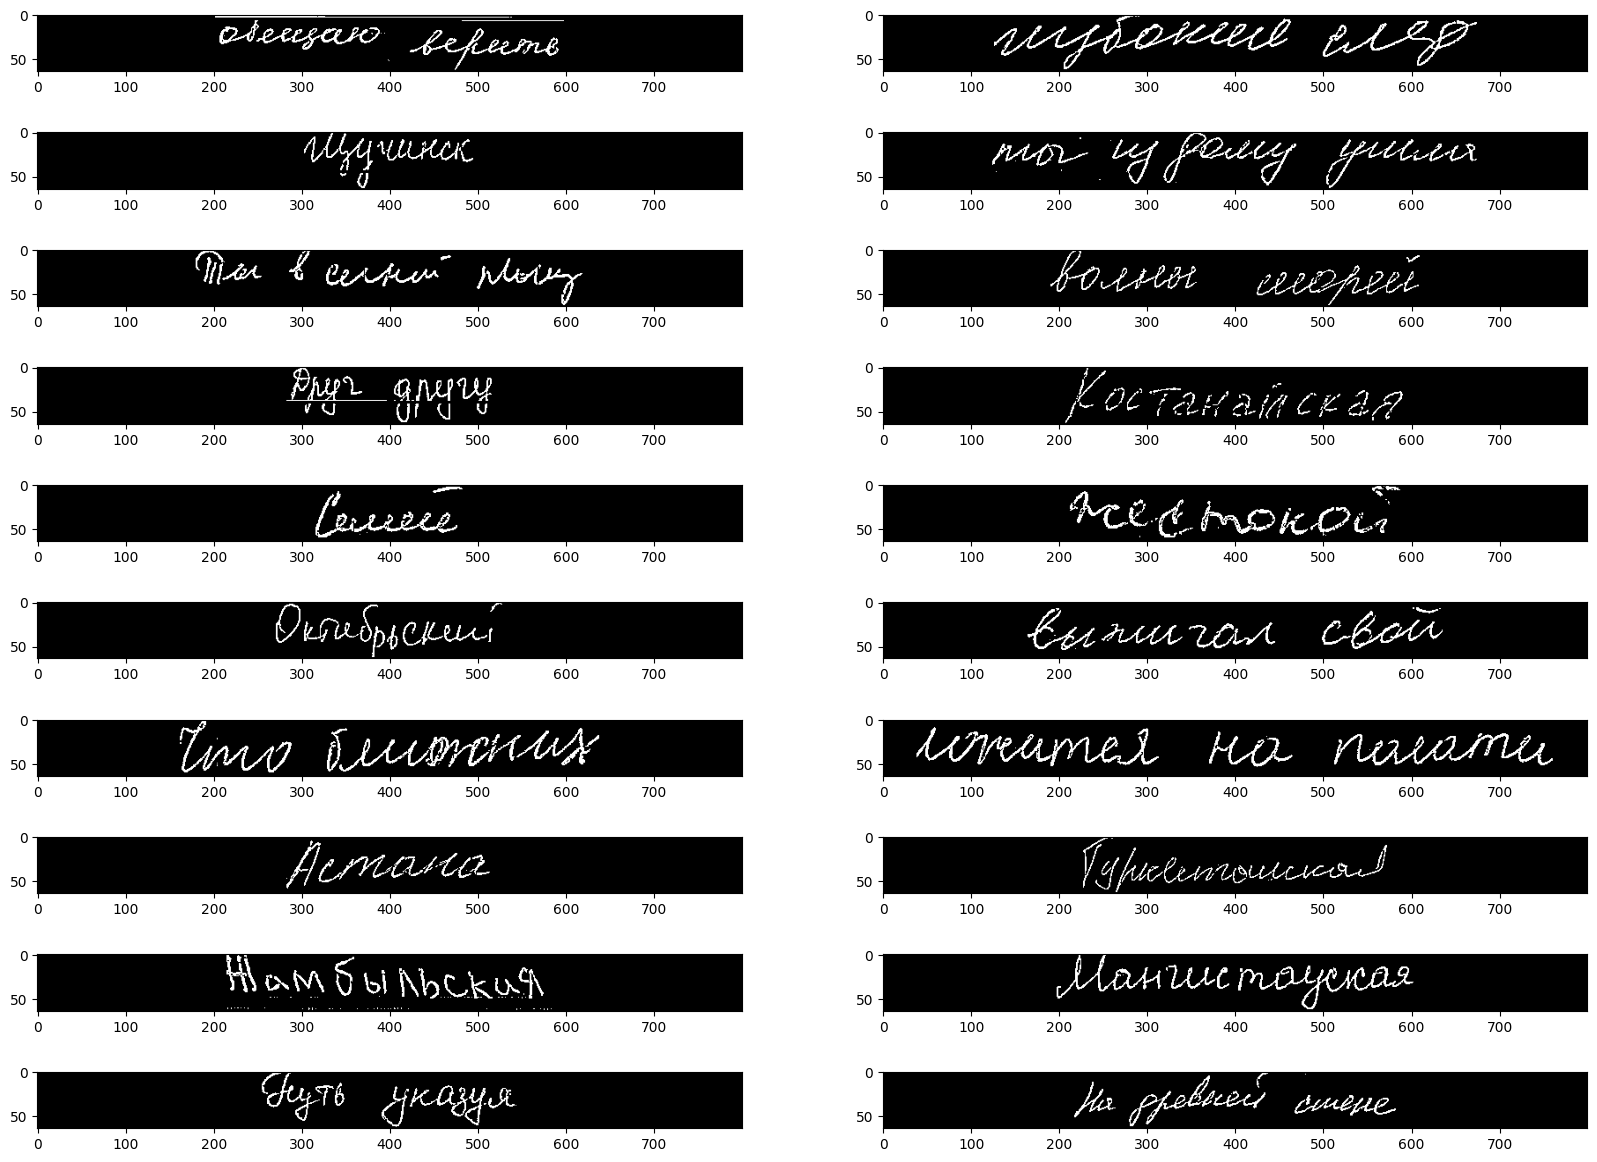

In [7]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)



for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (train_X[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

In [6]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [11]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(800, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Reshape((100, 512)))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 800, 64, 64)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 400, 32, 128)   │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 400, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 16, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 200, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 8, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 8, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 8, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 4, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 4, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 2, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 2, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 2, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 1, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 74)        │        37,962 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,969,738 (30.40 MB)

 Trainable params: 7,968,458 (30.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [13]:
model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

In [14]:
history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=75, batch_size=64,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric', mode='min'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric', mode='min')],
                    verbose=1)

Epoch 1/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 379s 588ms/step - CER_metric: 0.8243 - loss: 37.7005 - val_CER_metric: 0.2255 - val_loss: 8.0171 - learning_rate: 0.0010
Epoch 2/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 347s 570ms/step - CER_metric: 0.1655 - loss: 5.9183 - val_CER_metric: 0.1265 - val_loss: 4.5147 - learning_rate: 0.0010
Epoch 3/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 347s 569ms/step - CER_metric: 0.1029 - loss: 3.6589 - val_CER_metric: 0.1092 - val_loss: 3.9512 - learning_rate: 0.0010
Epoch 4/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 346s 568ms/step - CER_metric: 0.0769 - loss: 2.7030 - val_CER_metric: 0.0868 - val_loss: 3.0615 - learning_rate: 0.0010
Epoch 5/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 346s 568ms/step - CER_metric: 0.0611 - loss: 2.1500 - val_CER_metric: 0.0821 - val_loss: 2.9355 - learning_rate: 0.0010
Epoch 6/75
609/609 ━━━━━━━━━━━━━━━━━━━━ 346s 568ms/step - CER_metric: 0.0490 - loss: 1.7375 - val_CER_metric: 0.0710 - val_loss: 2.4934 - learning_rate: 0.0010
Epoch 7/75
609/609 ━━━━━━━━━━━━━━━━━━━━

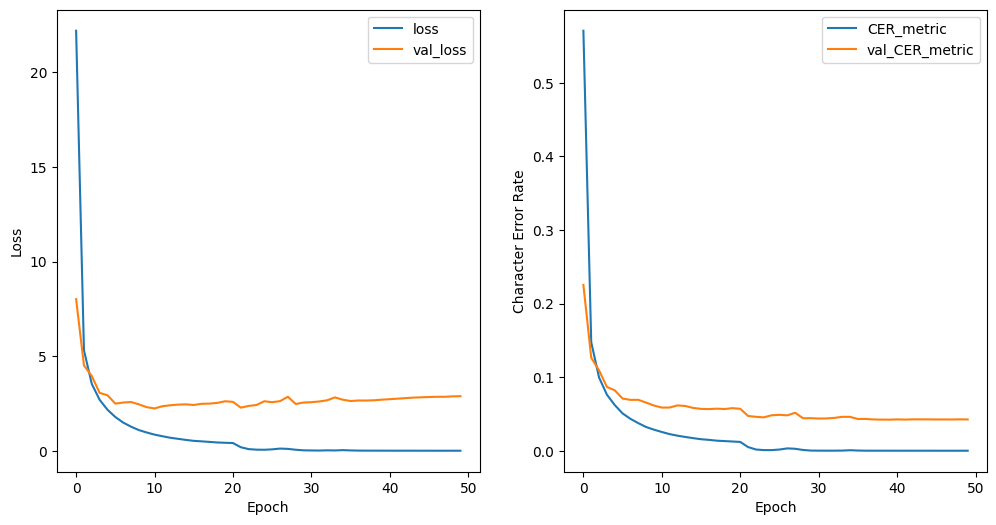

In [15]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [16]:
model.save('/kaggle/working/trained_crnn.h5')

In [7]:
model = load_model(
    '/kaggle/input/vg_crnn/keras/default/1/trained_crnn.h5', 
    custom_objects={
        'CTCLoss': CTCLoss, 
        'CERMetric': CERMetric, 
        'LeakyReLU': LeakyReLU  # Добавляем LeakyReLU в custom_objects
    }
)

# Проверим, что модель успешно загружена
print("Model loaded successfully!")

Model loaded successfully!


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 800, 64, 64)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 400, 32, 128)   │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 400, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 16, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 200, 8, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 8, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 8, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 8, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 4, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 4, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 2, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 2, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 2, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 1, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 512)       │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 85)        │        43,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,975,384 (30.42 MB)

 Trainable params: 7,974,101 (30.42 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 3 (16.00 B)

In [9]:
model.evaluate(test_X, test_y)

406/406 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - CER_metric: 0.0410 - loss: 2.6017


[2.6405396461486816, 0.0415918305516243]

In [10]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [11]:
predicts = model.predict(test_X)
predicts = decode_text(predicts)

406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step


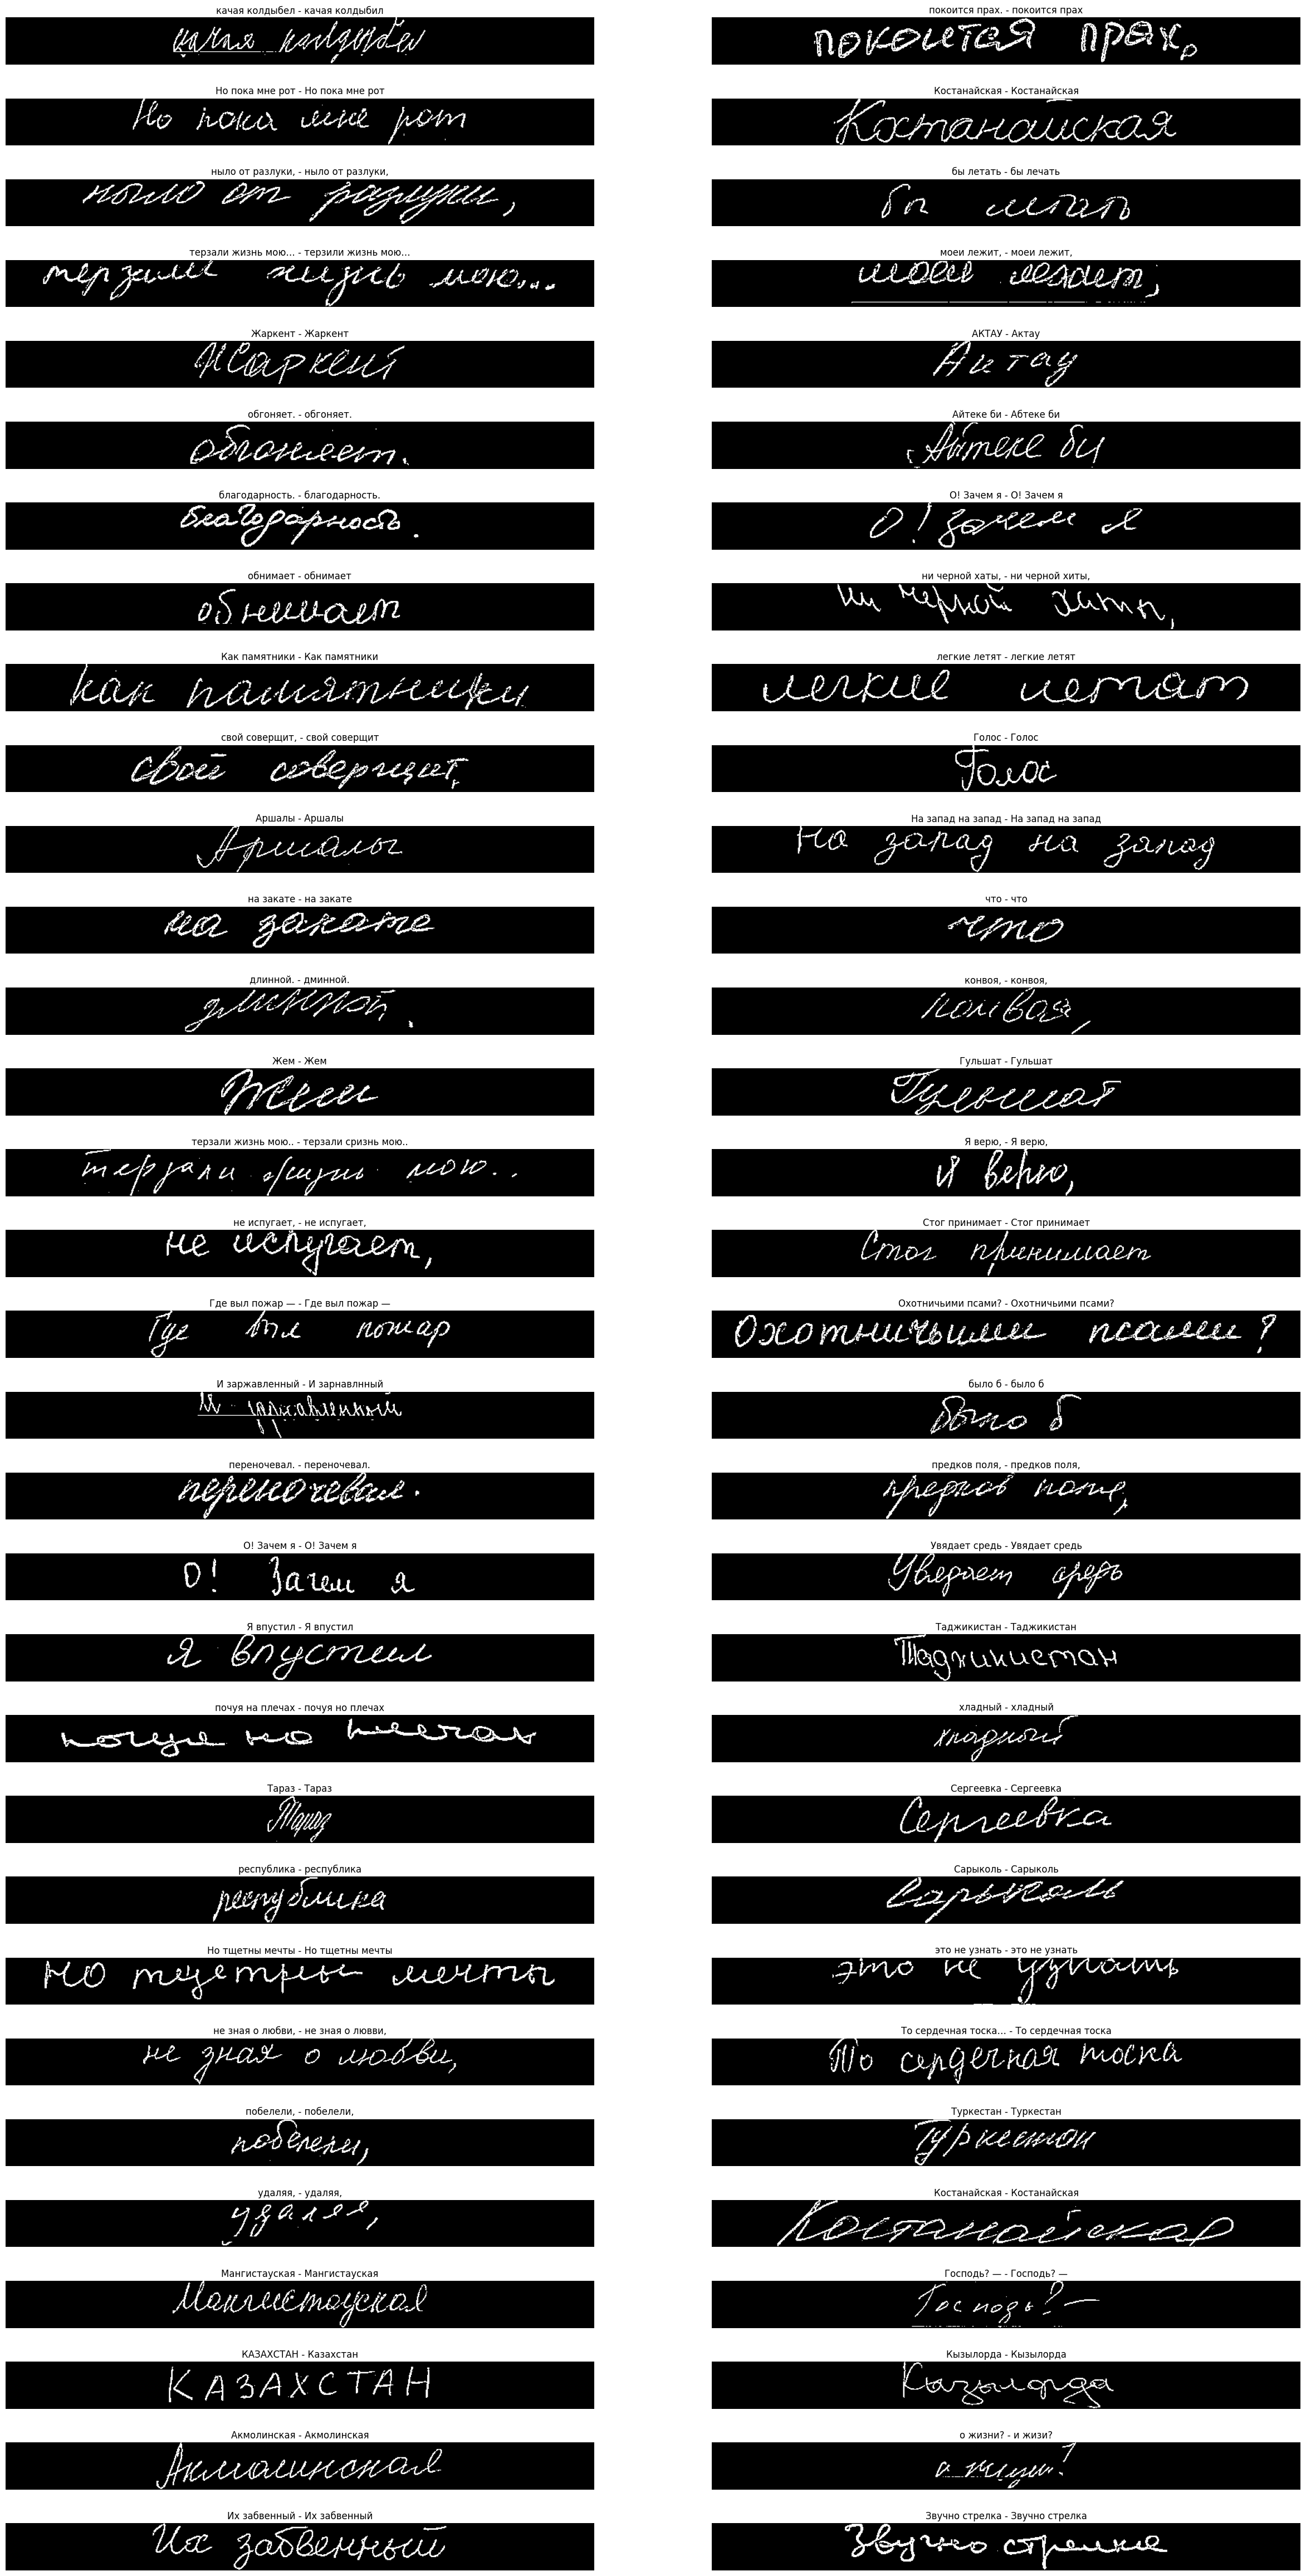

In [12]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")

# Попробуем загрузить наш датасет и сделать на нем предсказания

In [13]:
# Load labels
gt = pd.DataFrame(columns=['fn', 'value'])

with open('/kaggle/input/text-fields/fields_m/fields_m.txt', 'r') as f:
    for index, row in enumerate(f):
        if row[0] == '#':
            continue
        row = row.split()
        gt.loc[gt.shape[0]] = (row[0], row[-1].replace('|', ' '))
gt.head(5)

,fn,value
0,01_0002,Фамилия Кунарев
1,01_0004,Фамилия Кириллина
2,01_0005,Фамилия Сурова
3,01_0006,Фамилия Кузнецов
4,01_0007,Фамилия: Кузнецов


In [19]:
# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet_f):
    label_num = []
    for ch in label:
      label_num.append(alphabet_f.find(ch))
    return np.array(label_num)

  alphabet_f = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet_f)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet_f)

  return nums, alphabet_f

In [20]:
# Load and preprocess data
test_FX, test_fy = [], []

# Укажите путь к корневой папке с данными
root_folder = '/kaggle/input/text-fields/fields_m'

# Итерация по папкам 01, 02, 03
for sub_folder in tqdm(os.listdir(root_folder)):
    sub_folder_path = os.path.join(root_folder, sub_folder)  # Получаем путь к подкаталогу

    # Проверяем, что sub_folder_path это действительно папка
    if os.path.isdir(sub_folder_path):
        for image_file in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_file)  # Полный путь к файлу изображения

            # Извлекаем имя файла без расширения
            file_name_no_ext = image_file[:image_file.rfind('.')]

            # Получаем метку для текущего изображения
            label = gt[gt.fn == file_name_no_ext].value.tolist()[0]

            # Загружаем и предобрабатываем изображение
            image = preprocess(cv2.imread(image_path, 0))

            # Добавляем обработанное изображение и метку в соответствующие списки
            test_FX.append(image)
            test_fy.append(label)

# Преобразуем списки в массивы
test_FX = np.array(test_FX)

# Кодируем текстовые метки и получаем алфавит
test_fy, alphabet_f = encode_text(test_fy)

# Выводим или возвращаем алфавит
alphabet_f

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


' ()+-0123456789:АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщыьюя'

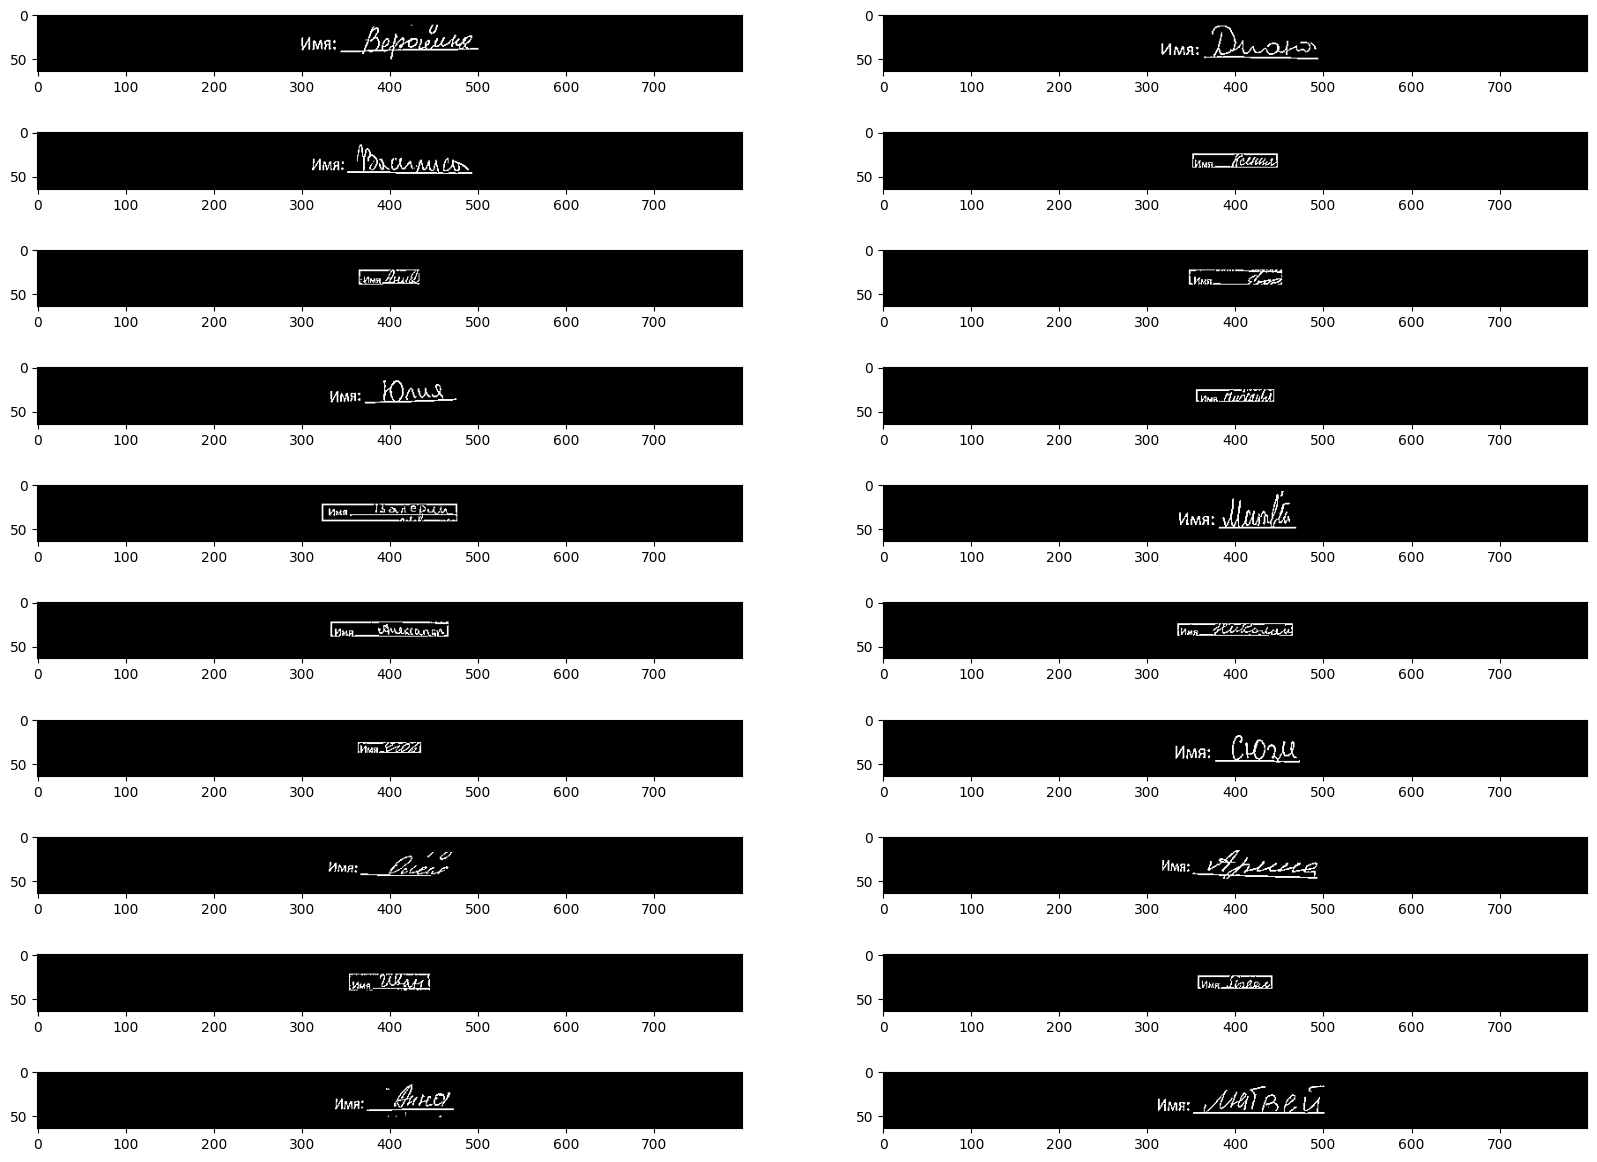

In [15]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (test_FX[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

In [22]:
predicts = model.predict(test_FX)
predicts = decode_text(predicts)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


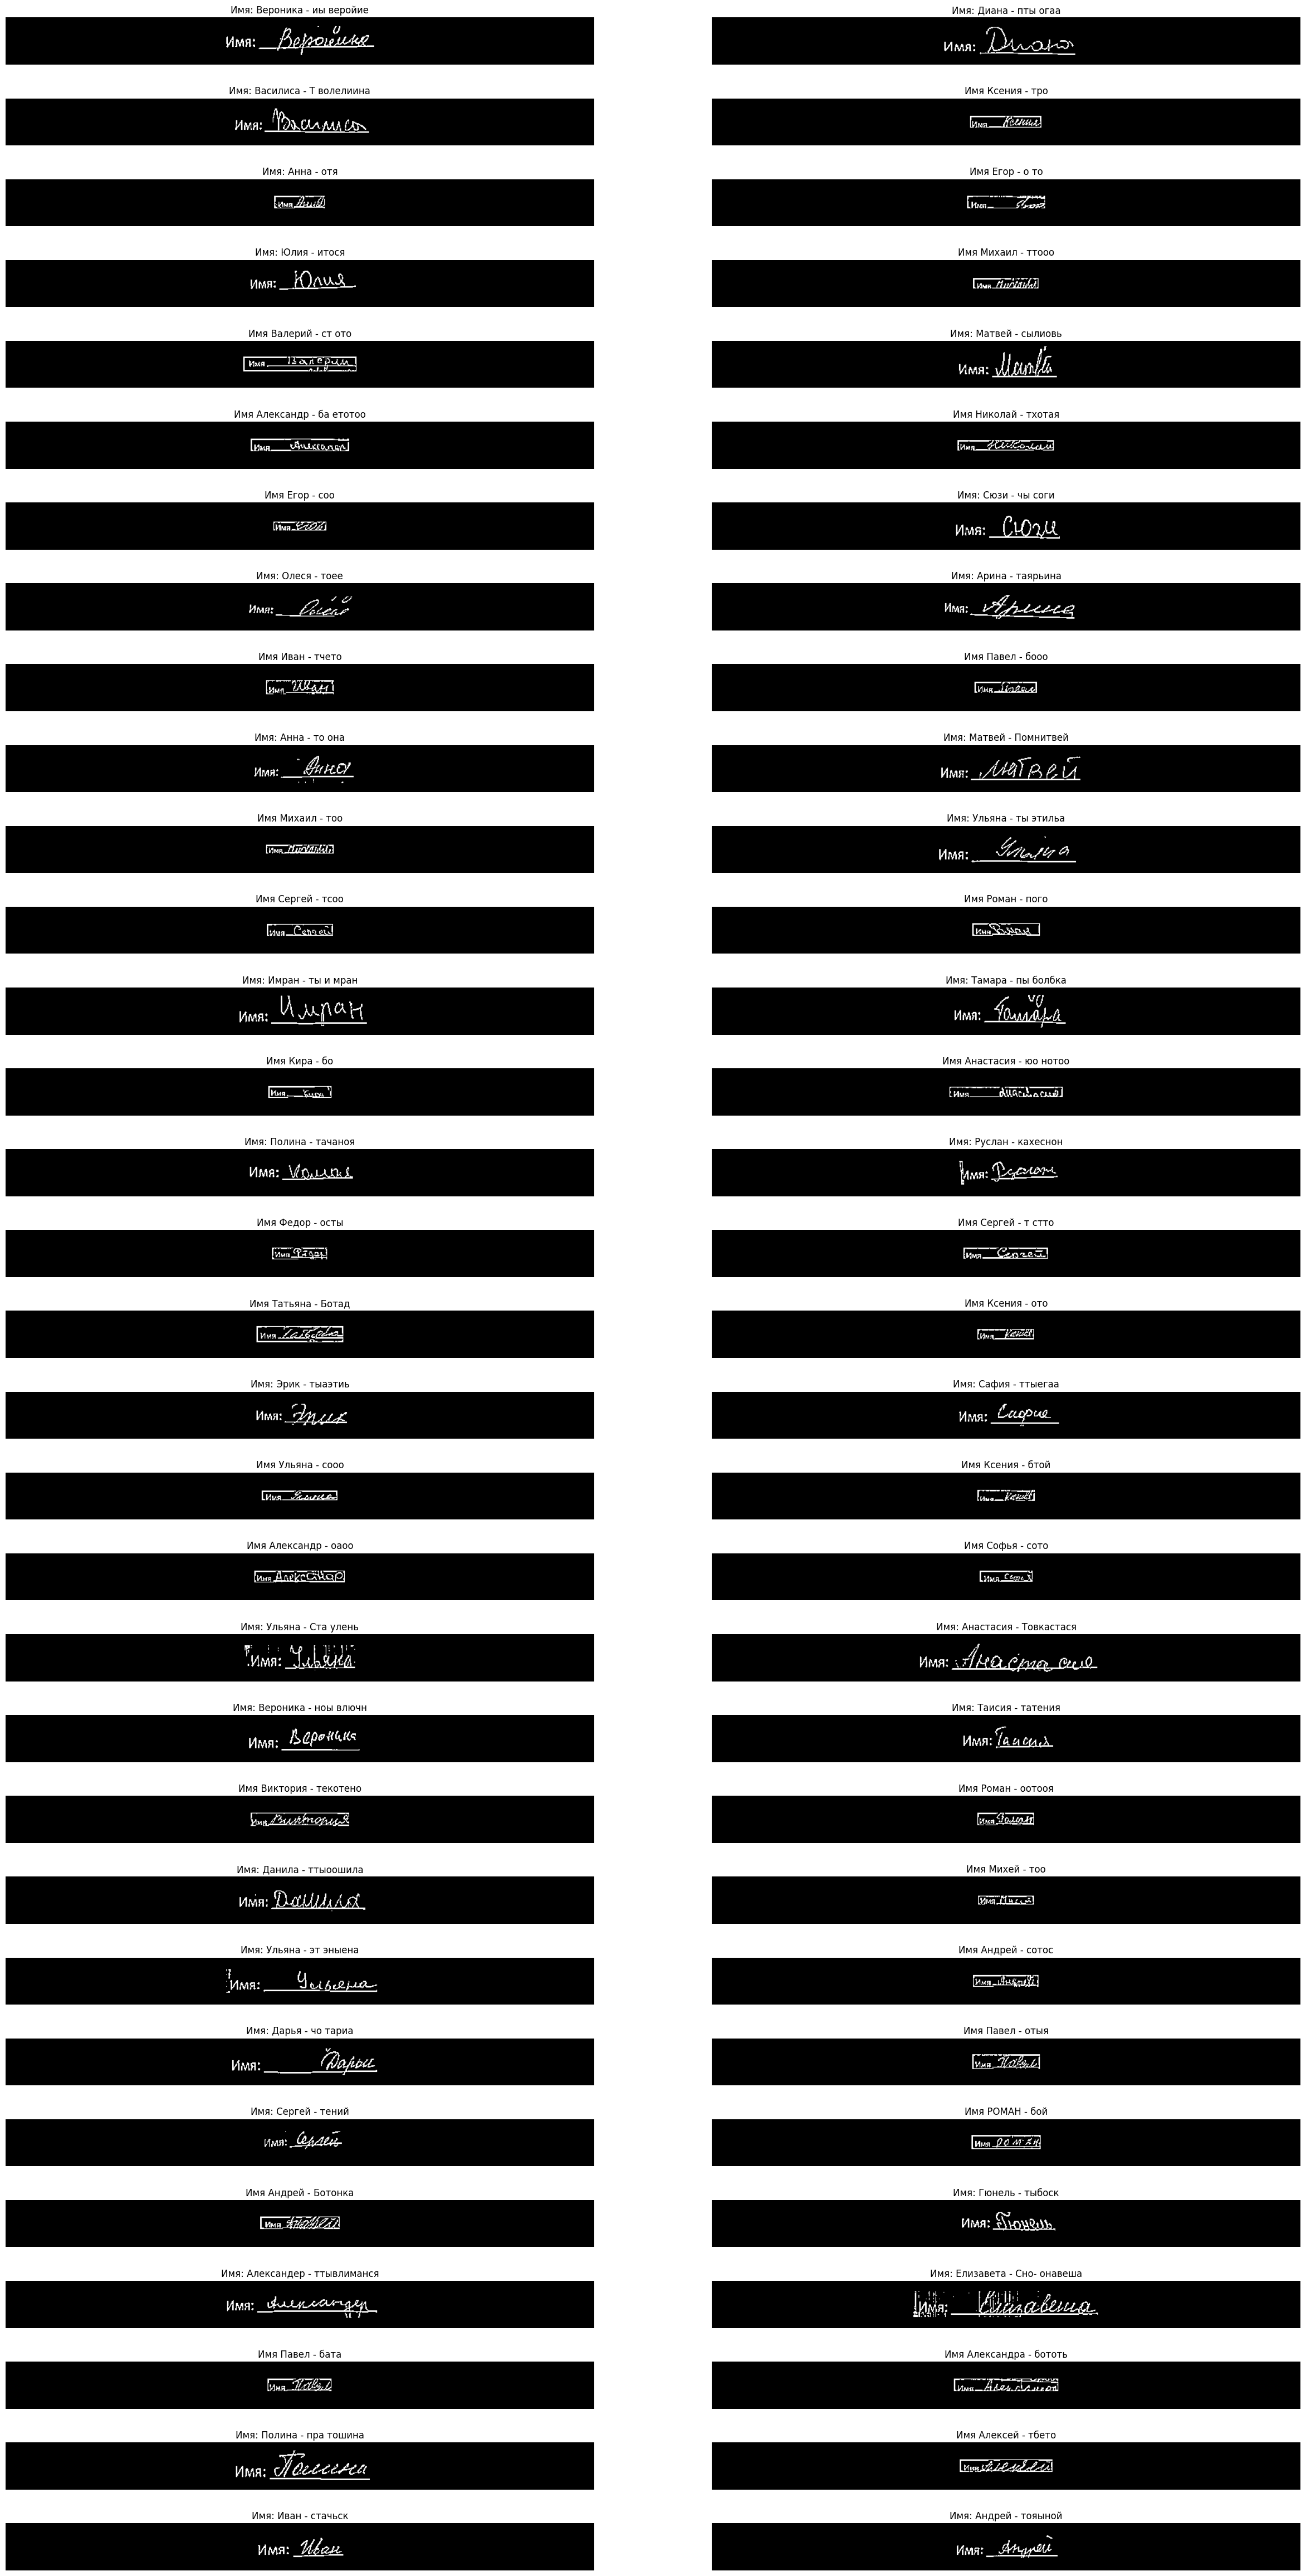

In [23]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_FX = test_FX.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_FX[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_fy[i], alphabet_f)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")